# TP RNN 
# Using Many-to-One for movie rating predicton

For any remark or suggestion, please feel free to contact me at:
geoffroy.peeters@telecom-paristech.fr

Last edit: 2019/01/15 geoffroy.peeters@telecom-paristech.fr

### Objective:
We will implement two different networks to perform automatic rating (0 or 1) of a movie given the text of its review.
We will use the ```imdb``` (internet movie database) dataset.

The reviews are already available in the form of indexes that point to a word dictionary: each word is already encoded as an index in the dictionary.

### Import packages

In [0]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Embedding, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras import Model
from keras import backend as K

## Parameters of the model

-  We only consider the ```top_words``` first words in the word dictionary
- We truncate/zerp-pad each sequence a length ```max_review_length````

In [0]:
top_words = 5000 
max_review_length = 100

## Import IMDB data

In [0]:
# Import the IMDB data and only consider the ``top_words``` most used words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [0]:
y_train[1]

0

## Data content

- ```X_train``` and ```X_test``` are numpy arrays of lists. 
  - each item in a list is the index in the word dictionary. So that a list is the sequence of index of words.

- ```y_train``` and ```y_test``` are a numpy arrays of the same dimension as ```X_train``` and ```X_test``` 
  - they contains the values 0 (bad movie) or 1 (good movie)

type(X_train): <class 'numpy.ndarray'>
number of training sequences: X_train.shape: (25000,)
type(X_train[0]): <class 'list'>
length of the first training sequence: len(X_train[0]): 218
length of the second training sequence: len(X_train[0]): 189
list of data of the first training sequence: X_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 

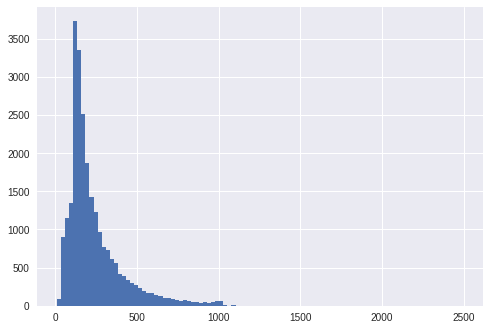

In [0]:
print("type(X_train):", type(X_train))
print("number of training sequences: X_train.shape:", X_train.shape)
print("type(X_train[0]):",type(X_train[0]))
print("length of the first training sequence: len(X_train[0]):",len(X_train[0]))
print("length of the second training sequence: len(X_train[0]):",len(X_train[1]))
print("list of data of the first training sequence: X_train[0]:", X_train[0] )
len_list = [len(train) for train in X_train]
print("maximum length of a training sequence:", max(len_list))

import matplotlib.pyplot as plt
plt.hist(len_list, 100);

In [0]:
print("type(y_train):", type(y_train))
print("y_train.shape:", y_train.shape)

type(y_train): <class 'numpy.ndarray'>
y_train.shape: (25000,)


In [0]:
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape: (25000,)
y_test.shape: (25000,)


## Data processing

Sequences (represented as a list of values) in ```X_train``` represent the reviews.
They can have different length.
To train the network we should modify them so that they all have the same length.
We do this by:
- truncating the ones that are too long
- padding-with-zero them the ones that are too short.

This is obtained using ```sequence.pad_sequences``` of keras.

In [0]:
# truncate and pad input sequences

# --- START CODE HERE
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# --- END CODE HERE

print("len(X_train[0]):", len(X_train[0]))
print("len(X_train[1]):", len(X_train[1]))
print("X_train[0]:", X_train[0])

len(X_train[0]): 100
len(X_train[1]): 100
X_train[0]: [1415   33    6   22   12  215   28   77   52    5   14  407   16   82
    2    8    4  107  117    2   15  256    4    2    7 3766    5  723
   36   71   43  530  476   26  400  317   46    7    4    2 1029   13
  104   88    4  381   15  297   98   32 2071   56   26  141    6  194
    2   18    4  226   22   21  134  476   26  480    5  144   30    2
   18   51   36   28  224   92   25  104    4  226   65   16   38 1334
   88   12   16  283    5   16 4472  113  103   32   15   16    2   19
  178   32]


## First model

In the first model, we will simply 
- learn a word embedding  (```Embedding``` layer in keras) and apply it to each of item of a sequence, 
  -  in keras, embedding is not a matrix going from one-hot-encoding to embedding, it is a layer that goes from index-in-word-dictionary to embedding
  - the embedding goes from a catalogue of words of size```top_words``` dimensions to  ```embedding_vector_length``` dimensions
- average the embedding obtained for each word of a seuqnece over all words of the sequence (you should use ```K.mean``` from the keras backend https://keras.io/backend/ and ```Lambda``` https://keras.io/layers/core/ ) 
- apply a fully connected (```Dense``` layer in keras) which output activation is a sigmoid ()predicting the 0 or 1 rating)



In [0]:
K.clear_session()

In [0]:
# create the model
embedding_vector_length = 32 

#Le réseau va sortir a(Tx)
#(m,Tx,nx) : on ne connait pas m le nb d'exemple : Tx = dim temporelle et nx dim de chaque variable
#(m,Tx,nx) = (None, 100, 2994)
# --- START CODE HERE
X = Input(shape=(max_review_length,))
X1 = Embedding(input_dim = top_words, output_dim = embedding_vector_length,input_length=max_review_length)(X) #va donner (m,Tx,embedding_vector_length)
X2 = Lambda(lambda x: K.mean(x, axis=1))(X1)
Y = Dense(1,activation = 'sigmoid')(X2)
model = Model(inputs = X, outputs = Y)
# --- END CODE HERE


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 3s 139us/step - loss: 0.6357 - acc: 0.7304 - val_loss: 0.5592 - val_acc: 0.7774
Epoch 2/3
25000/25000 [==============================] - 3s 111us/step - loss: 0.4844 - acc: 0.8139 - val_loss: 0.4389 - val_acc: 0.8231
Epoch 3/3
25000/25000 [==============================] - 3s 106us/step - loss: 0.3931 - acc: 0.8455 - val_loss: 0.3855 - val_acc: 0.8359


##Results

After only 3 epochs, you should obtain an accuracy around 84% for the test data.

## Second model

In the second model, we will replace
- average the obtained embedding over the sequence (use ```K.mean``` and ```Lambda```from keras backend)
- by a RNN layer (more precisely an ```LSTM```) in a Many-To-One configuration with $n_a=100$


In [0]:
K.clear_session()

In [0]:
# create the model

# --- START CODE HERE
X = Input(shape=(max_review_length,))
print(X)
X1 = Embedding(input_dim = top_words, output_dim = embedding_vector_length,input_length=max_review_length)(X) #va donner (m,Tx,embedding_vector_length)
print(X1)
X2 = LSTM(100, return_sequences = False)(X1) #False permet de faire le many to one
print(X2)
Y = Dense(1, activation = 'sigmoid')(X2)
print(Y)
model = Model(inputs = X, outputs = Y)
# --- END CODE HERE

print(model.summary())

Tensor("input_1:0", shape=(?, 100), dtype=float32)
Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, 100, 32), dtype=float32)
Tensor("lstm_1/TensorArrayReadV3:0", shape=(?, 100), dtype=float32)
Tensor("dense_1/Sigmoid:0", shape=(?, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# compile and fit the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test))


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 73s 3ms/step - loss: 0.4557 - acc: 0.7735 - val_loss: 0.3628 - val_acc: 0.8412
Epoch 2/3
25000/25000 [==============================] - 70s 3ms/step - loss: 0.3034 - acc: 0.8754 - val_loss: 0.3436 - val_acc: 0.8537
Epoch 3/3
25000/25000 [==============================] - 69s 3ms/step - loss: 0.2539 - acc: 0.8984 - val_loss: 0.3505 - val_acc: 0.8514


## Results

After only 3 epochs, you should obtain an accuracy around 88% for the test data.